# 1) Imports

In [1]:
# Common imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from string import punctuation
from gensim import matutils
from gensim.corpora import Dictionary
import gensim

In [2]:
# Natural language processing imports
import nltk
from gensim.corpora import Dictionary
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize 
from nltk.corpus import stopwords
import gensim.corpora as corpora
from nltk import pos_tag

In [3]:
# topic model imports
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import CoherenceModel

In [4]:
# hyperparameter training imports
from sklearn.model_selection import GridSearchCV

In [5]:
# visualization imports
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [6]:
# feature selection imports
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [7]:
# final model imports

In [8]:
# metrics imports
from sklearn.metrics import accuracy_score
from collections import Counter

In [9]:
# progress imports
import numpy as np
from tqdm import tqdm

In [10]:
%matplotlib inline
sns.set()  

# 2) Data Import

In [11]:
data = pd.read_csv('Combined_News_DJIA.csv')
news = data.drop(['Label'], axis=1)
fin_data = pd.read_csv('upload_DJIA_table.csv')
print("Shape of data: {}.\nShape of fin_data: {}".format(news.shape, fin_data.shape))

Shape of data: (1989, 26).
Shape of fin_data: (1989, 7)


In [12]:
news_fin = pd.merge(news, fin_data, on=['Date']) 
news_fin['Date'] = pd.to_datetime(news_fin['Date']) 
# We are ging to predict the 'Open' price of the next day.

news_fin.head(3)

,Date,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,...,Top22,Top23,Top24,Top25,Open,High,Low,Close,Volume,Adj Close
0,2008-08-08,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",b'Georgian troops retreat from S. Osettain cap...,...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge""",11432.089844,11759.959961,11388.040039,11734.320312,212830000,11734.320312
1,2008-08-11,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,b'Welcome To World War IV! Now In High Definit...,...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo...",11729.669922,11867.110352,11675.530273,11782.349609,183190000,11782.349609
2,2008-08-12,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...","b""The US military was surprised by the timing ...",...,b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man...",11781.700195,11782.349609,11601.519531,11642.469727,173590000,11642.469727


In [13]:
X = news_fin.drop(['Open', 'Close'], axis=1)
y = news_fin[['Date', 'Adj Close']]
y = y.iloc[1:]

In [14]:
# Date          Open        High        Low         Close       Adj Close   Volume
# 07 Aug 2008	11,655.42	11,655.58	11,416.70	11,431.43	11,431.43	2,296,100
# Jul 05, 2016	17,904.45	17,904.45	17,785.28	17,840.62	17,840.62	103,650,000

y_last = pd.DataFrame(data=[['2016-07-05', 17840.62]], columns=['Date', 'Adj Close'])
y_last['Date'] = pd.to_datetime(y_last['Date'])

y = pd.concat([y, y_last], axis=0)
y = y.reset_index(drop=True)

In [15]:
y

# Since I am predicting the open price of the next market day, I had to get the historical price for the day after the last
# data point and append it to the output. I also had to remove the first open price as it was the not the 'next' open price
# for any of the data points.

,Date,Adj Close
0,2008-08-11,11782.349609
1,2008-08-12,11642.469727
2,2008-08-13,11532.959961
3,2008-08-14,11615.929688
4,2008-08-15,11659.900391
...,...,...
1984,2016-06-28,17409.720703
1985,2016-06-29,17694.679688
1986,2016-06-30,17929.990234
1987,2016-07-01,17949.369141


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
X_train1 = X_train
X_train = X_train.drop(['Date'], axis=1)
X_test1 = X_test
X_test = X_test.drop(['Date'], axis=1)
y_train1 = y_train
y_test1 = y_test

In [17]:
len(X_train)

1591

In [18]:
# from sklearn.preprocessing import Normalizer

# scaler = Normalizer()
# test = scaler.fit_transform(y_train['Adj Close'].to_numpy().reshape((-1,1)))

# plt.hist(test, bins=20)dd

In [19]:
# plt.hist(y_train['Adj Close'], bins=20)

# 3) Data Visualisation and Inspection
Firstly, we will try and understand our data by performing exploratory commands aiming to look at the headlines and checking for and dealing with missing data

In [20]:
# Check if there is any missing data in the data
X_train.isnull().sum()

Top1         0
Top2         0
Top3         0
Top4         0
Top5         0
Top6         0
Top7         0
Top8         0
Top9         0
Top10        0
Top11        0
Top12        0
Top13        0
Top14        0
Top15        0
Top16        0
Top17        0
Top18        0
Top19        0
Top20        0
Top21        0
Top22        0
Top23        1
Top24        3
Top25        3
High         0
Low          0
Volume       0
Adj Close    0
dtype: int64

In [21]:
# There is 1 missing headline in Top23 column, 2 missing headlines in Top24
# and 2 more missing headlines in Top25. We will replace these NaN values
# with ' '
def replace_missing(df):
    df1 = pd.DataFrame()
    df1 = df.replace(np.nan, ' ', regex=True)
    print(df1.isnull().sum().sum())
    
    return df1

X_train = replace_missing(X_train)

0


In [22]:
# Let us just look at the head of the data:
X_train.head(3)

,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,...,Top20,Top21,Top22,Top23,Top24,Top25,High,Low,Volume,Adj Close
0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",b'Georgian troops retreat from S. Osettain cap...,b'Did the U.S. Prep Georgia for War with Russia?',...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge""",11759.959961,11388.040039,212830000,11734.320312
1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,b'Welcome To World War IV! Now In High Definit...,"b""Georgia's move, a mistake of monumental prop...",...,b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo...",11867.110352,11675.530273,183190000,11782.349609
2,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...","b""The US military was surprised by the timing ...",b'U.S. Beats War Drum as Iran Dumps the Dollar',...,b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man...",11782.349609,11601.519531,173590000,11642.469727


We can see each headline has this b' or b" at the beginning with a ' or " at the end of the headline. Before Visualising the data I will get rid of this

In [23]:
def initial_preprocessing(df):
    df1 = pd.DataFrame()
    df1 = df.replace('b\"|b\'|\\\\|\\\"', '', regex=True)  # 'or' separating 4 expressions to be replaced
    return df1
    
X_train = initial_preprocessing(X_train)

### Inspect Target Variable

Text(0.5, 0, 'Date')

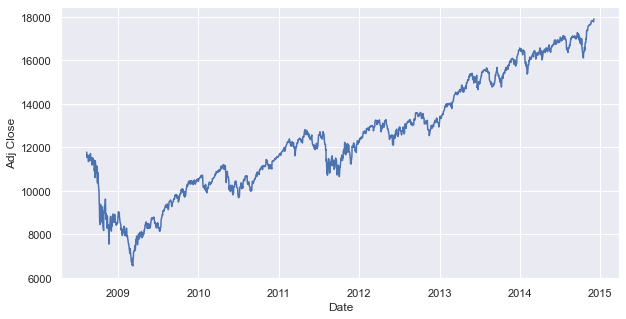

In [24]:
plt.figure(figsize=(10,5))
plt.plot(y_train['Date'], y_train['Adj Close'])
plt.ylabel('Adj Close')
plt.xlabel('Date')

### Inspect Text Input Variables

In [25]:
headlines = X_train['Top1'].append([X_train[col] for col in X_train.iloc[:,1:25]], ignore_index=True)
headlines.reset_index(drop=True, inplace=True)

headline_lengths = np.array(list(map(len, headlines.str.split(' '))))

print("Average word length of a headline: {}.".format(np.mean(headline_lengths)))
print("Minimum word length of a headline: {}.".format(min(headline_lengths)))
print("Maximum word length of a headline: {}.".format(max(headline_lengths)))

Average word length of a headline: 17.764399748585795.
Minimum word length of a headline: 2.
Maximum word length of a headline: 64.


C:\Users\HP\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


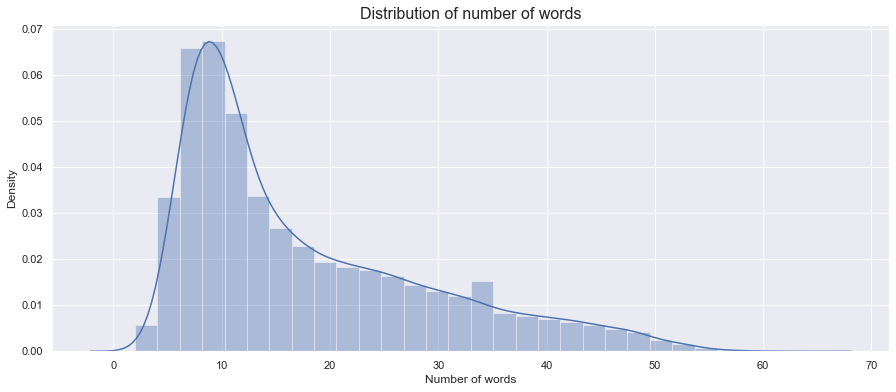

In [26]:
# I want to see the distribution of the lengths of the headlines.

fig, ax = plt.subplots(figsize=(15,6))

ax.set_title("Distribution of number of words", fontsize=16)
ax.set_xlabel("Number of words")

sns.distplot(headline_lengths, bins=30, ax=ax);

As you can see, most headlines are quite short. They are not typically long as you would expect. There seems to be quite a lot of headlines with less than 10 words. I will next inspect headlines of length 2 and 3.

In [27]:
print("There are {} headlines with over 40 words.".format(sum(headline_lengths > 40)))

There are 2446 headlines with over 40 words.


In [28]:
# So many headlines with varying lengths, penalising high headline lengths 
# will not change the distribution too much as you can see. Not only this,
# In the process I remove 2446 headlines by penalising long worded headlines
# This could be alot of useful data.

# I want to look at headlines with small word lengths.
# It is particularly interesting to see the previously NaN headlines that I
# replaced with ' ', have length 2 and not length 1. 
# In time however I will be stripping spaces so they will be length 0. 

headlines[headline_lengths == 2]

366      Haiti 360....AMAZING!'
11188            Terrorism Act'
25653       Rotterdam, Eurabia'
25985       Murdoch's Watergate
30235               NATO's Hour
35279                          
36870                          
36941                          
37274                          
38218              Harper Hunt'
38461                          
38532                          
38865                          
dtype: object

In [29]:
headlines[headline_lengths <5].count()

473

The headlines of length 3 still seem imformative, especially 'China bans youtube' this may be a significant headline. The headlines of length 2 however are a little more ambiguous, however 'Terrorism Act' and 'Murdochs Watergate' tell enough information to the reader to provide a postive or negative sentiment for example.

It is hard to remove headlines (fields of data), as this will cause an uneven amount of input variables for row of data (This will be explained further later) and cause errors in the classification process.

There is an issue with the data, for exmaple [LIBYA]Battle, and U.S, and 9-year-old in headlines. I need to remove the punctuation. For two of the example I need to add replace spaces for the punctuation as otherwise we will get one word. But 'U.S' needs to be combined.

So I will come up with a small algorithm to deal with this in 4.2

# 4) Data Pre-processing
1. Lower
2. Punctuation
3. Remove numbers
4. Tokenize
5. Stop word removal
6. Lemmatize
7. N-gram (bigram) + noise removal part 1
8. Dictionary + noise removal part 2

### 4.1) Lower case

In [30]:
def lower_case(df):
    df1 = pd.DataFrame()
    for col in df:
        if col in ['High', 'Low', 'Adj Close', 'Volume']: 
            df1[col] = df[col]
        else:
            df1[col] = df[col].str.lower()
    
    return df1

X_train = lower_case(X_train)

### 4.2) Punctuation removal

In [31]:
def strip_punctuation(s):
    for i in range(len(s)):
        if s[i] == '[' or s[i] == ']'  or s[i] == '-':
            s = s.replace('[',' ')
            s = s.replace(']',' ')
            s = s.replace('-',' ')
            
    return ''.join(c for c in s if c not in punctuation)

def remove_punctuation_from_all(df):
    df1 = pd.DataFrame()
    for col in df:
        if col in ['High', 'Low', 'Adj Close', 'Volume']: 
            df1[col] = df[col]
        else:
            df1[col] = df[col].apply(strip_punctuation)
        
    return df1

X_train = remove_punctuation_from_all(X_train)
X_train.head(3)

,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,...,Top20,Top21,Top22,Top23,Top24,Top25,High,Low,Volume,Adj Close
0,georgia downs two russian warplanes as countri...,breaking musharraf to be impeached,russia today columns of troops roll into south...,russian tanks are moving towards the capital o...,afghan children raped with impunity un officia...,150 russian tanks have entered south ossetia w...,breaking georgia invades south ossetia russia ...,the enemy combatent trials are nothing but a s...,georgian troops retreat from s osettain capita...,did the us prep georgia for war with russia,...,georgia will withdraw 1000 soldiers from iraq ...,why the pentagon thinks attacking iran is a ba...,caucasus in crisis georgia invades south ossetia,indian shoe manufactory and again in a seri...,visitors suffering from mental illnesses banne...,no help for mexicos kidnapping surge,11759.959961,11388.040039,212830000,11734.320312
1,why wont america and nato help us if they wont...,bush puts foot down on georgian conflict,jewish georgian minister thanks to israeli tra...,georgian army flees in disarray as russians ad...,olympic opening ceremony fireworks faked,what were the mossad with fraudulent new zeala...,russia angered by israeli military sale to geo...,an american citizen living in sossetia blames ...,welcome to world war iv now in high definition,georgias move a mistake of monumental proporti...,...,war in south ossetia pics,israeli physicians group condemns state torture,russia has just beaten the united states over...,perhaps the question about the georgia russi...,russia is so much better at war,so this is what its come to trading sex for food,11867.110352,11675.530273,183190000,11782.349609
2,remember that adorable 9 year old who sang at ...,russia ends georgia operation,if we had no sexual harassment we would have n...,al qaeda is losing support in iraq because of ...,ceasefire in georgia putin outmaneuvers the west,why microsoft and intel tried to kill the xo 1...,stratfor the russo georgian war and the balanc...,im trying to get a sense of this whole georgia...,the us military was surprised by the timing an...,us beats war drum as iran dumps the dollar,...,remember that adorable 62 year old who led you...,war in georgia the israeli connection,all signs point to the us encouraging georgia ...,christopher king argues that the us and nato a...,america the new mexico,bbc news asia pacific extinction by man not ...,11782.349609,11601.519531,173590000,11642.469727


### 4.3 Remove numbers

In [32]:
def remove_numbers(df):
    df1 = pd.DataFrame()
    for col in df:
        if col in ['High', 'Low', 'Adj Close', 'Volume']: 
            df1[col] = df[col]
        else:
            df1[col] = df[col].apply(lambda text: ''.join(c for c in text if not c.isdigit()))
    
    return df1

X_train = remove_numbers(X_train)

### 4.4) Tokenize

In [33]:
def tokenize(df):
    df1 = pd.DataFrame()
    for col in df:
        if col in ['High', 'Low', 'Adj Close', 'Volume']: 
            df1[col] = df[col]
        else:
            df1[col] = df[col].apply(nltk.word_tokenize)
    
    return df1

X_train = tokenize(X_train)
X_train_old_tokenized = X_train
X_train.head(3)

,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,...,Top20,Top21,Top22,Top23,Top24,Top25,High,Low,Volume,Adj Close
0,"[georgia, downs, two, russian, warplanes, as, ...","[breaking, musharraf, to, be, impeached]","[russia, today, columns, of, troops, roll, int...","[russian, tanks, are, moving, towards, the, ca...","[afghan, children, raped, with, impunity, un, ...","[russian, tanks, have, entered, south, ossetia...","[breaking, georgia, invades, south, ossetia, r...","[the, enemy, combatent, trials, are, nothing, ...","[georgian, troops, retreat, from, s, osettain,...","[did, the, us, prep, georgia, for, war, with, ...",...,"[georgia, will, withdraw, soldiers, from, iraq...","[why, the, pentagon, thinks, attacking, iran, ...","[caucasus, in, crisis, georgia, invades, south...","[indian, shoe, manufactory, and, again, in, a,...","[visitors, suffering, from, mental, illnesses,...","[no, help, for, mexicos, kidnapping, surge]",11759.959961,11388.040039,212830000,11734.320312
1,"[why, wont, america, and, nato, help, us, if, ...","[bush, puts, foot, down, on, georgian, conflict]","[jewish, georgian, minister, thanks, to, israe...","[georgian, army, flees, in, disarray, as, russ...","[olympic, opening, ceremony, fireworks, faked]","[what, were, the, mossad, with, fraudulent, ne...","[russia, angered, by, israeli, military, sale,...","[an, american, citizen, living, in, sossetia, ...","[welcome, to, world, war, iv, now, in, high, d...","[georgias, move, a, mistake, of, monumental, p...",...,"[war, in, south, ossetia, pics]","[israeli, physicians, group, condemns, state, ...","[russia, has, just, beaten, the, united, state...","[perhaps, the, question, about, the, georgia, ...","[russia, is, so, much, better, at, war]","[so, this, is, what, its, come, to, trading, s...",11867.110352,11675.530273,183190000,11782.349609
2,"[remember, that, adorable, year, old, who, san...","[russia, ends, georgia, operation]","[if, we, had, no, sexual, harassment, we, woul...","[al, qaeda, is, losing, support, in, iraq, bec...","[ceasefire, in, georgia, putin, outmaneuvers, ...","[why, microsoft, and, intel, tried, to, kill, ...","[stratfor, the, russo, georgian, war, and, the...","[im, trying, to, get, a, sense, of, this, whol...","[the, us, military, was, surprised, by, the, t...","[us, beats, war, drum, as, iran, dumps, the, d...",...,"[remember, that, adorable, year, old, who, led...","[war, in, georgia, the, israeli, connection]","[all, signs, point, to, the, us, encouraging, ...","[christopher, king, argues, that, the, us, and...","[america, the, new, mexico]","[bbc, news, asia, pacific, extinction, by, man...",11782.349609,11601.519531,173590000,11642.469727


### 4.5) Stopword removal

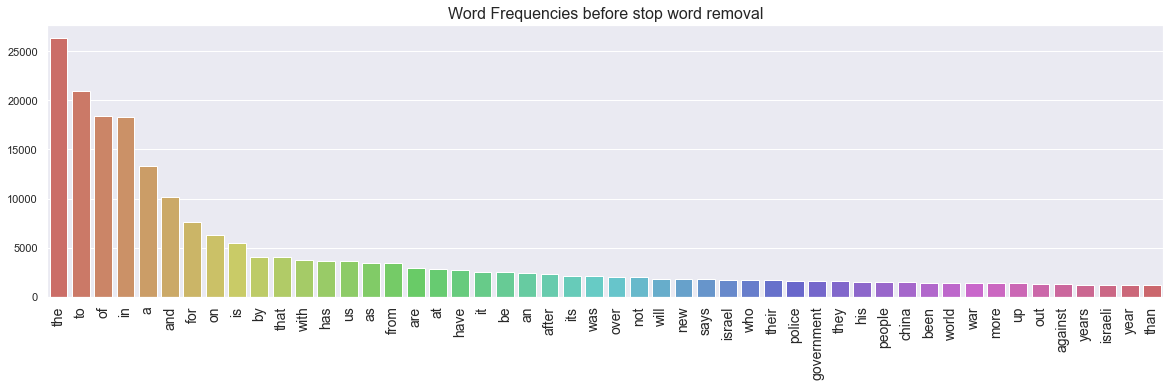

In [34]:
tokenized_headlines = X_train['Top1'].append([X_train[col] for col in X_train.iloc[:,1:25]], ignore_index=True)

tokenized_only_dict = Counter(np.concatenate(tokenized_headlines.values))

tokenized_only_df = pd.DataFrame.from_dict(tokenized_only_dict, orient='index')
tokenized_only_df.rename(columns={0:'count'}, inplace=True)

tokenized_only_df.sort_values('count', ascending=False, inplace=True)

def word_frequency_barplot(df, nr_top_words=50):
    """ df should have a column named count.
    """
    fig, ax = plt.subplots(1,1,figsize=(20,5))

    sns.barplot(x=list(range(nr_top_words)), y=df['count'].values[:nr_top_words], palette='hls', ax=ax)

    ax.set_xticks(list(range(nr_top_words)))
    ax.set_xticklabels(df.index[:nr_top_words], fontsize=14, rotation=90)
    return ax
    
ax = word_frequency_barplot(tokenized_only_df)
ax.set_title("Word Frequencies before stop word removal", fontsize=16);

Interesting to see 'us' just as popular as some stop words, hence why it is removed as well as stopwords below. 

Also 'us' was lemitized to 'u', in the lemmitization stage, which is confusing and another reason for its removal.

In [35]:
stopword = stopwords.words('english')
stopword.append('us')

def remove_stopwords(df):
    df1 = pd.DataFrame()
    for col in df:
        if col in ['High', 'Low', 'Adj Close', 'Volume']: 
            df1[col] = df[col]
        else:
            df1[col] = df[col].apply(lambda x: [item for item in x if item not in stopword])
        
    return df1

X_train = remove_stopwords(X_train)
X_train.head(3)

,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,...,Top20,Top21,Top22,Top23,Top24,Top25,High,Low,Volume,Adj Close
0,"[georgia, downs, two, russian, warplanes, coun...","[breaking, musharraf, impeached]","[russia, today, columns, troops, roll, south, ...","[russian, tanks, moving, towards, capital, sou...","[afghan, children, raped, impunity, un, offici...","[russian, tanks, entered, south, ossetia, whil...","[breaking, georgia, invades, south, ossetia, r...","[enemy, combatent, trials, nothing, sham, sali...","[georgian, troops, retreat, osettain, capital,...","[prep, georgia, war, russia]",...,"[georgia, withdraw, soldiers, iraq, help, figh...","[pentagon, thinks, attacking, iran, bad, idea,...","[caucasus, crisis, georgia, invades, south, os...","[indian, shoe, manufactory, series, like, work]","[visitors, suffering, mental, illnesses, banne...","[help, mexicos, kidnapping, surge]",11759.959961,11388.040039,212830000,11734.320312
1,"[wont, america, nato, help, wont, help, help, ...","[bush, puts, foot, georgian, conflict]","[jewish, georgian, minister, thanks, israeli, ...","[georgian, army, flees, disarray, russians, ad...","[olympic, opening, ceremony, fireworks, faked]","[mossad, fraudulent, new, zealand, passports, ...","[russia, angered, israeli, military, sale, geo...","[american, citizen, living, sossetia, blames, ...","[welcome, world, war, iv, high, definition]","[georgias, move, mistake, monumental, proporti...",...,"[war, south, ossetia, pics]","[israeli, physicians, group, condemns, state, ...","[russia, beaten, united, states, head, peak, oil]","[perhaps, question, georgia, russia, conflict]","[russia, much, better, war]","[come, trading, sex, food]",11867.110352,11675.530273,183190000,11782.349609
2,"[remember, adorable, year, old, sang, opening,...","[russia, ends, georgia, operation]","[sexual, harassment, would, children]","[al, qaeda, losing, support, iraq, brutal, cra...","[ceasefire, georgia, putin, outmaneuvers, west]","[microsoft, intel, tried, kill, xo, laptop]","[stratfor, russo, georgian, war, balance, power]","[im, trying, get, sense, whole, georgia, russi...","[military, surprised, timing, swiftness, russi...","[beats, war, drum, iran, dumps, dollar]",...,"[remember, adorable, year, old, led, country, ...","[war, georgia, israeli, connection]","[signs, point, encouraging, georgia, invade, s...","[christopher, king, argues, nato, behind, geor...","[america, new, mexico]","[bbc, news, asia, pacific, extinction, man, cl...",11782.349609,11601.519531,173590000,11642.469727


### 4.6) Lemmatization

In [36]:
# https://www.kaggle.com/alvations/basic-nlp-with-nltk
#nltk.download('averaged_perceptron_tagger')

wordnet_lemmatizer = WordNetLemmatizer()

def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n' # if mapping isn't found, fall back to Noun.

def lemmatize(df):
    df1 = pd.DataFrame()
    for col in df:
        if col in ['High', 'Low', 'Adj Close', 'Volume']: 
            df1[col] = df[col]
        else:
            df1[col] = df[col].apply(lambda x: [wordnet_lemmatizer.lemmatize(word, pos=penn2morphy(tag)) for word, tag in pos_tag(x)])
        
    return df1

X_train = lemmatize(X_train)

In [37]:
X_train.head(3)

,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,...,Top20,Top21,Top22,Top23,Top24,Top25,High,Low,Volume,Adj Close
0,"[georgia, down, two, russian, warplane, countr...","[break, musharraf, impeach]","[russia, today, columns, troop, roll, south, o...","[russian, tank, move, towards, capital, south,...","[afghan, child, rap, impunity, un, official, s...","[russian, tank, enter, south, ossetia, whilst,...","[break, georgia, invades, south, ossetia, russ...","[enemy, combatent, trial, nothing, sham, salim...","[georgian, troop, retreat, osettain, capital, ...","[prep, georgia, war, russia]",...,"[georgia, withdraw, soldier, iraq, help, fight...","[pentagon, think, attack, iran, bad, idea, new...","[caucasus, crisis, georgia, invades, south, os...","[indian, shoe, manufactory, series, like, work]","[visitor, suffer, mental, illness, ban, olympics]","[help, mexicos, kidnapping, surge]",11759.959961,11388.040039,212830000,11734.320312
1,"[wont, america, nato, help, wont, help, help, ...","[bush, put, foot, georgian, conflict]","[jewish, georgian, minister, thanks, israeli, ...","[georgian, army, flees, disarray, russian, adv...","[olympic, open, ceremony, firework, fake]","[mossad, fraudulent, new, zealand, passport, i...","[russia, anger, israeli, military, sale, georgia]","[american, citizen, live, sossetia, blame, geo...","[welcome, world, war, iv, high, definition]","[georgia, move, mistake, monumental, proportion]",...,"[war, south, ossetia, pic]","[israeli, physician, group, condemn, state, to...","[russia, beaten, united, state, head, peak, oil]","[perhaps, question, georgia, russia, conflict]","[russia, much, well, war]","[come, trading, sex, food]",11867.110352,11675.530273,183190000,11782.349609
2,"[remember, adorable, year, old, sang, open, ce...","[russia, end, georgia, operation]","[sexual, harassment, would, child]","[al, qaeda, lose, support, iraq, brutal, crack...","[ceasefire, georgia, putin, outmaneuvers, west]","[microsoft, intel, try, kill, xo, laptop]","[stratfor, russo, georgian, war, balance, power]","[im, try, get, sense, whole, georgia, russia, ...","[military, surprise, time, swiftness, russian,...","[beat, war, drum, iran, dump, dollar]",...,"[remember, adorable, year, old, lead, country,...","[war, georgia, israeli, connection]","[sign, point, encourage, georgia, invade, sout...","[christopher, king, argues, nato, behind, geor...","[america, new, mexico]","[bbc, news, asia, pacific, extinction, man, cl...",11782.349609,11601.519531,173590000,11642.469727


### 4.7) N-gram (bigram) + noise removal part 1

In [38]:
# Build the bigram and trigram models
def n_gram(df, choice):
    headlines = df['Top1'].append([df[col] for col in df.iloc[:,1:25]], ignore_index=True)
    
    bigram = gensim.models.Phrases(headlines, min_count=5, threshold=1) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[headlines], min_count=2, threshold=1)

    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    
    if choice == 2:
        return [bigram_mod[doc] for doc in headlines]
    elif choice == 3:
        return [trigram_mod[bigram_mod[doc]] for doc in headlines]

# Form Bigrams/Trigrams
data_words_bigrams = n_gram(X_train, 2)
#data_words_trigrams = n_gram(X_train, 3)

### 4.8) Dictionary (and corpus creation) + noise removal part 2

In [39]:
def generate_lda_parameters(texts):

    # Create Dictionary
    id2word = corpora.Dictionary(texts)
    id2word.filter_extremes(no_below=5, no_above=0.5)

    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]
    
    return texts, id2word, corpus

texts, id2word, corpus = generate_lda_parameters(data_words_bigrams)
#texts, id2word, corpus = generate_lda_parameters(data_words_trigrams)

Preprocessing steps are now complete. The following cell just puts all of the preprocessing steps into a single function for easy preparation of the test set.

In [40]:
def preprocess(df):
    df1 = df
    df1 = replace_missing(df1)
    df1 = initial_preprocessing(df1)
    df1 = lower_case(df1)
    df1 = remove_punctuation_from_all(df1)
    df1 = remove_numbers(df1)
    df1 = tokenize(df1)
    df1 = remove_stopwords(df1)
    df1 = lemmatize(df1)
    bigrams = n_gram(df1, 2)
    #trigrams = n_gram(df1, 3)
    texts, id2word, corpus = generate_lda_parameters(bigrams)
    #texts, id2word, corpus = generate_lda_parameters(trigrams)

    return df1, texts, id2word, corpus

# 5) LDA Model
1. LDA and evaluation procedure
2. K grid search
3. Analysis of K
4. Manual Topic Inspection
5. Alpha and beta grid search
6. Analysis of alpha and beta

### 5.1) LDA and evaluation procedure

In [41]:
def lda_evaluation(texts, corpus, dictionary, k, *args, **kwargs):
    a = kwargs.get('a', None)
    b = kwargs.get('b', None)
    lda_model = None
    
    if a==None or b==None:
         lda_model = LdaMulticore(corpus=corpus,
                                 id2word=dictionary,
                                 num_topics=k, 
                                 random_state=100,
                                 chunksize=100,
                                 passes=20,
                                 per_word_topics=True)
    else:
        lda_model = LdaMulticore(corpus=corpus,
                                 id2word=dictionary,
                                 num_topics=k, 
                                 random_state=100,
                                 chunksize=100,
                                 passes=20,
                                 alpha=a,
                                 eta=b,
                                 per_word_topics=True)
    
    cm = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence = cm.get_coherence()
    
    perplexity = lda_model.log_perplexity(corpus)
    
    return coherence, perplexity

### 5.2) Best K (num of topics) grid search

In [42]:
# model_results = {'Topics': [],
#                  'Coherence': [], 
#                  'Perplexity': []}

# with tqdm(total=29) as pbar: 
    
#     for k in range(10, 151, 5): # min, max, step_size
        
#         cv, perp = lda_evaluation(texts, corpus, id2word, k)

#         model_results['Topics'].append(k)
#         model_results['Coherence'].append(cv)
#         model_results['Perplexity'].append(perp)

#         pbar.update(1)
                    
#     pd.DataFrame(model_results).to_csv('lda_k_results.csv', index=False)
#     pbar.close()

### 5.3) Analysis of K

In [43]:
results = pd.read_csv('lda_k_results.csv')

Text(0, 0.5, 'Log Perplexity')

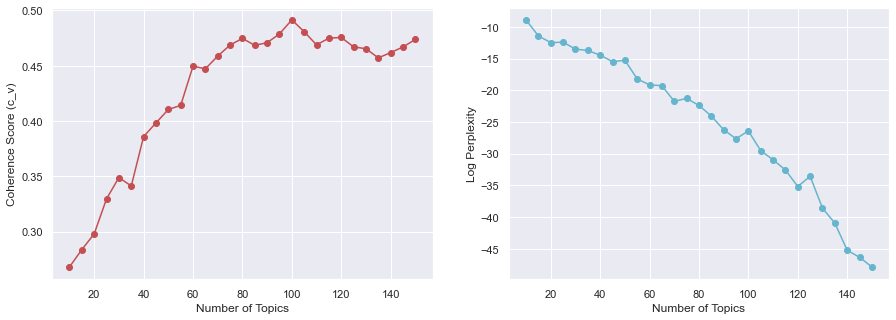

In [44]:
fig = plt.figure()
fig.set_size_inches(15, 5)

ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax.plot(results['Topics'], results['Coherence'], '-o', color='r')
ax.set_xlabel('Number of Topics')
ax.set_ylabel('Coherence Score (c_v)')

ax2.plot(results['Topics'], results['Perplexity'], '-o', color='c')
ax2.set_xlabel('Number of Topics')
ax2.set_ylabel('Log Perplexity')

From the graphs above, I have chosen to inspect more closely the following values of k, k = [30, 40, 45, 50, 60]

### 5.4) Manual Topic Inspection

In [45]:
# lda_models = []

# lda_models.append(LdaMulticore(corpus=corpus, id2word=id2word, num_topics=30, random_state=100,
#                                  chunksize=100, passes=20, per_word_topics=True))

# lda_models.append(LdaMulticore(corpus=corpus, id2word=id2word, num_topics=40, random_state=100,
#                                  chunksize=100, passes=20, per_word_topics=True))

# lda_models.append(LdaMulticore(corpus=corpus, id2word=id2word, num_topics=45, random_state=100,
#                                  chunksize=100, passes=20, per_word_topics=True))

# lda_models.append(LdaMulticore(corpus=corpus, id2word=id2word, num_topics=50, random_state=100,
#                                  chunksize=100, passes=20, per_word_topics=True))

# lda_models.append(LdaMulticore(corpus=corpus, id2word=id2word, num_topics=60, random_state=100,
#                                  chunksize=100, passes=20, per_word_topics=True))

In [46]:
# topics30 = {'Topic ' + str(i+1): [token for token, score in lda_models[0].show_topic(i, topn=5)] for i in range(0, lda_models[0].num_topics)}
# topics40 = {'Topic ' + str(i+1): [token for token, score in lda_models[1].show_topic(i, topn=5)] for i in range(0, lda_models[1].num_topics)}
# topics45 = {'Topic ' + str(i+1): [token for token, score in lda_models[2].show_topic(i, topn=5)] for i in range(0, lda_models[2].num_topics)}
# topics50 = {'Topic ' + str(i+1): [token for token, score in lda_models[3].show_topic(i, topn=5)] for i in range(0, lda_models[3].num_topics)}
# topics60 = {'Topic ' + str(i+1): [token for token, score in lda_models[4].show_topic(i, topn=5)] for i in range(0, lda_models[4].num_topics)}

In [47]:
# topics30
# a lot of topics merging together

In [48]:
# topics40
# Still a few topics merging together and a lot of them not really clear

In [49]:
#topics45
# Some topics seem too fine grained. Need a smaller k.

In [50]:
#topics50

In [51]:
#topics60

In [52]:
# lda_models.append(LdaMulticore(corpus=corpus, id2word=id2word, num_topics=47, random_state=100,
#                                 chunksize=100, passes=20, per_word_topics=True))

# lda_models.append(LdaMulticore(corpus=corpus, id2word=id2word, num_topics=48, random_state=100,
#                                  chunksize=100, passes=20, per_word_topics=True))

# topics47 = {'Topic ' + str(i+1): [token for token, score in lda_models[5].show_topic(i, topn=5)] for i in range(0, lda_models[5].num_topics)}
# topics48 = {'Topic ' + str(i+1): [token for token, score in lda_models[6].show_topic(i, topn=5)] for i in range(0, lda_models[6].num_topics)}

In [53]:
#topics47

In [54]:
#topics48

In [55]:
# lda_models.append(LdaMulticore(corpus=corpus, id2word=id2word, num_topics=46, random_state=100,
#                                  chunksize=100, passes=20, per_word_topics=True))

In [56]:
#topics46 = {'Topic ' + str(i+1): [token for token, score in lda_models[7].show_topic(i, topn=5)] for i in range(0, lda_models[7].num_topics)}

In [57]:
#topics46

In [58]:
#cm40 = CoherenceModel(model=lda_models[1], texts=texts, dictionary=id2word, coherence='c_v')
#coherence40 = cm40.get_coherence()
#perplexity40 = lda_models[1].log_perplexity(corpus)

# cm45 = CoherenceModel(model=lda_models[2], texts=texts, dictionary=id2word, coherence='c_v')
# coherence45 = cm45.get_coherence()
# perplexity45 = lda_models[2].log_perplexity(corpus)

# cm46 = CoherenceModel(model=lda_models[7], texts=texts, dictionary=id2word, coherence='c_v')
# coherence46 = cm46.get_coherence()
# perplexity46 = lda_models[7].log_perplexity(corpus)

# cm47 = CoherenceModel(model=lda_models[5], texts=texts, dictionary=id2word, coherence='c_v')
# coherence47 = cm47.get_coherence()
# perplexity47 = lda_models[5].log_perplexity(corpus)

# cm48 = CoherenceModel(model=lda_models[6], texts=texts, dictionary=id2word, coherence='c_v')
# coherence48 = cm48.get_coherence()
# perplexity48 = lda_models[6].log_perplexity(corpus)

# cm50 = CoherenceModel(model=lda_models[3], texts=texts, dictionary=id2word, coherence='c_v')
# coherence50 = cm50.get_coherence()
# perplexity50 = lda_models[3].log_perplexity(corpus)

In [59]:
# print('K=40, c_v={}, log_perp={}'.format(coherence40, perplexity40))
# print('K=45, c_v={}, log_perp={}'.format(coherence45, perplexity45))
# print('K=46, c_v={}, log_perp={}'.format(coherence46, perplexity46))
# print('K=47, c_v={}, log_perp={}'.format(coherence47, perplexity47))
# print('K=48, c_v={}, log_perp={}'.format(coherence48, perplexity48))
# print('K=50, c_v={}, log_perp={}'.format(coherence50, perplexity50))

In [60]:
# lda_models.append(LdaMulticore(corpus=corpus, id2word=id2word, num_topics=42, random_state=100,
#                                  chunksize=100, passes=20, per_word_topics=True))

# lda_models.append(LdaMulticore(corpus=corpus, id2word=id2word, num_topics=43, random_state=100,
#                                  chunksize=100, passes=20, per_word_topics=True))

In [61]:
# topics42 = {'Topic ' + str(i+1): [token for token, score in lda_models[8].show_topic(i, topn=5)] for i in range(0, lda_models[8].num_topics)}
# topics43 = {'Topic ' + str(i+1): [token for token, score in lda_models[9].show_topic(i, topn=5)] for i in range(0, lda_models[9].num_topics)}

In [62]:
# cm42 = CoherenceModel(model=lda_models[8], texts=texts, dictionary=id2word, coherence='c_v')
# coherence42 = cm42.get_coherence()
# perplexity42 = lda_models[8].log_perplexity(corpus)

# cm43 = CoherenceModel(model=lda_models[9], texts=texts, dictionary=id2word, coherence='c_v')
# coherence43 = cm43.get_coherence()
# perplexity43 = lda_models[9].log_perplexity(corpus)

In [63]:
#topics42

In [64]:
# topics43

In [65]:
# lda_models.append(LdaMulticore(corpus=corpus, id2word=id2word, num_topics=41, random_state=100,
#                                  chunksize=100, passes=20, per_word_topics=True))
# cm41 = CoherenceModel(model=lda_models[10], texts=texts, dictionary=id2word, coherence='c_v')
# coherence41 = cm41.get_coherence()
# perplexity41 = lda_models[10].log_perplexity(corpus)

In [66]:
# lda_models.append(LdaMulticore(corpus=corpus, id2word=id2word, num_topics=44, random_state=100,
#                                  chunksize=100, passes=20, per_word_topics=True))
# cm44 = CoherenceModel(model=lda_models[11], texts=texts, dictionary=id2word, coherence='c_v')
# coherence44 = cm44.get_coherence()
# perplexity44 = lda_models[11].log_perplexity(corpus)

In [67]:
# df = pd.DataFrame(data=[[41,coherence41,perplexity41],
#                        [42,coherence42,perplexity42],
#                        [43,coherence43,perplexity43],
#                        [44,coherence44,perplexity44],
#                        [46,coherence43,perplexity46],
#                        [47,coherence47,perplexity47],
#                        [48,coherence48,perplexity48]], columns=['Topics','Coherence','Perplexity'])

In [68]:
# df

In [69]:
# fig = plt.figure()
# fig.set_size_inches(15, 5)

# ax = fig.add_subplot(121)
# ax2 = fig.add_subplot(122)

# ax.plot(results.iloc[:11,:]['Topics'], results.iloc[:11,:]['Coherence'], 'o', color='r')
# ax.plot(df['Topics'], df['Coherence'], 'o', color='r')
# ax.set_xlabel('Number of Topics')
# ax.set_ylabel('Coherence Score (c_v)')

# ax2.plot(results.iloc[:11,:]['Topics'], results.iloc[:11,:]['Perplexity'], 'o', color='c')
# ax2.plot(df['Topics'], df['Perplexity'], 'o', color='c')
# ax2.set_xlabel('Number of Topics')
# ax2.set_ylabel('Log Perplexity')

The struggle is that, although there may be more human hunderstandable topics in one topic model than another, due to the unsupervised nature of the algorithm, there will be topics that appear to have no similarity to human known topics. Moreover, topic models with larger k may have more un-interpretable topics, however the quality of their more interpretable topics may be higher than that of the topic models with lower k, for this reason I had to find a balence. Therefore, I have chosen to pick 43, which is between 40 and 50, I became undecided between the two, and tested values of K in between these two values. I noticed the topics between these values of K were very good, however the rate of change of the value of c_v was not significant enough to pick K=50 for example. I chose K=47.

### 5.5) Alpha and Beta grid search

In [70]:
# model_results_alpha_beta = {'alpha': [],
#                             'beta': [],
#                             'Coherence': [], 
#                             'Perplexity': []}

# alphas = [0.001, 0.01, 0.1, 1.0, 10]
# alphas.append('symmetric')
# alphas.append('asymmetric')

# betas = [0.001, 0.01, 0.1, 1.0, 10]
# betas.append('symmetric')

# with tqdm(total=42) as pbar: 
    
#     for alpha in alphas: 
#         for beta in betas:
        
#             cv, perp = lda_evaluation(texts, corpus, id2word, 47, alpha, beta)

#             model_results_alpha_beta['alpha'].append(alpha)
#             model_results_alpha_beta['beta'].append(beta)
#             model_results_alpha_beta['Coherence'].append(cv)
#             model_results_alpha_beta['Perplexity'].append(perp)

#             pbar.update(1)
                    
#     pd.DataFrame(model_results_alpha_beta).to_csv('lda_alpha_beta_results.csv', index=False)
#     pbar.close()

### 5.6) Analysis of alpha and beta

In [71]:
ab_results = pd.read_csv('lda_alpha_beta_results.csv')
ab_results.head()

,alpha,beta,Coherence,Perplexity
0,0.001,0.001,0.400591,-15.783553
1,0.001,0.01,0.401464,-16.023522
2,0.001,0.1,0.392559,-15.486285
3,0.001,1.0,0.400133,-15.496655
4,0.001,10,0.398382,-14.845308


Text(0, 0.5, 'Coherence (c_v)')

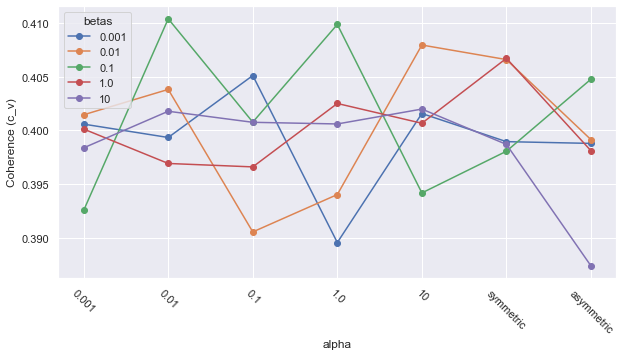

In [72]:
plt.figure(figsize=(10,5))
betas = [0.001, 0.01, 0.1, 1.0, 10]
for beta in betas:
    temp = ab_results[ab_results['beta'] == str(beta)]
    plt.plot(temp['alpha'], temp['Coherence'], '-o', label=str(beta))
plt.legend(loc='best', title='betas')
plt.xticks(rotation=-45)
plt.xlabel('alpha')
plt.ylabel('Coherence (c_v)')

Text(0, 0.5, 'Log Perplexity')

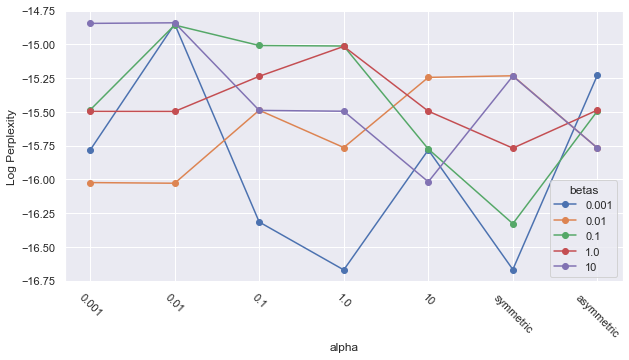

In [73]:
plt.figure(figsize=(10,5))
for beta in betas:
    temp = ab_results[ab_results['beta'] == str(beta)]
    plt.plot(temp['alpha'], temp['Perplexity'], '-o', label=str(beta))
plt.legend(loc='best', title='betas')
plt.xticks(rotation=-45)
plt.xlabel('alpha')
plt.ylabel('Log Perplexity')

I will use k=47, alpha=0.01, beta=0.1

# 6) Train and Test Data Format Procedure

In [74]:
lda_model = LdaMulticore(corpus=corpus,
                         id2word=id2word,
                         num_topics=47, 
                         random_state=100,
                         chunksize=100,
                         passes=20,
                         alpha=0.01,
                         eta=0.1,
                         per_word_topics=True)

In [75]:
def document_to_lda_features(lda_model, document):
    """ Transforms a bag of words document to features.
    It returns the proportion of how much each topic was
    present in the document.
    """
    #print(document)
    topic_importances = lda_model.get_document_topics(document, minimum_probability=0)
    topic_importances = np.array(topic_importances)
    return topic_importances[:,1]

# get topic probabilities, put them in a table, normalize and concatinate 'open' values into table also
def format_data(df, corpus, lda_model, rows, cols):
    probs = list(map(lambda doc: document_to_lda_features(lda_model, doc), corpus))
    
    probs1 = np.reshape(probs,(-1,rows))
        
    return np.transpose(probs1)
    

X_train_topic_probs = format_data(X_train, corpus, lda_model, len(X_train.index), len(X_train.columns))

In [76]:
X_train_topic_probs

array([[1.18083030e-03, 6.21505737e-01, 6.07270340e-04, ...,
        5.26242591e-02, 2.23750691e-03, 1.80459827e-01],
       [1.22570679e-01, 1.06642671e-01, 6.07270340e-04, ...,
        4.65962104e-04, 2.23750691e-03, 1.18085381e-03],
       [1.18083030e-03, 1.05611223e-03, 6.07270340e-04, ...,
        4.65962104e-04, 2.23750691e-03, 1.18085381e-03],
       ...,
       [1.05611223e-03, 6.07270340e-04, 1.33899052e-03, ...,
        2.25985304e-01, 1.87788859e-01, 1.33886386e-03],
       [1.05611223e-03, 6.07270340e-04, 4.35969800e-01, ...,
        2.23750691e-03, 1.18085381e-03, 1.33886386e-03],
       [1.05611223e-03, 6.54680654e-02, 1.33899052e-03, ...,
        2.23750691e-03, 1.40454829e-01, 1.33886386e-03]])

# 7) Process Test Data

In [77]:
X_test, texts_test, id2word_test, corpus_test = preprocess(X_test)

0


In [78]:
lda_model_test = LdaMulticore(corpus=corpus_test,
                         id2word=id2word_test,
                         num_topics=47, 
                         random_state=100,
                         chunksize=100,
                         passes=20,
                         alpha=0.01,
                         eta=0.1,
                         per_word_topics=True)

In [79]:
X_test_topic_probs = format_data(X_test, corpus_test, lda_model, len(X_test.index), len(X_test.columns))

In [80]:
X_test_topic_probs

array([[0.00095527, 0.00182859, 0.00051405, ..., 0.00223818, 0.08954699,
        0.00080257],
       [0.09868822, 0.00182859, 0.00051405, ..., 0.00223818, 0.04495892,
        0.00080257],
       [0.00095527, 0.00182859, 0.20187947, ..., 0.00223818, 0.00044567,
        0.00080257],
       ...,
       [0.00182859, 0.00051405, 0.00105619, ..., 0.04499275, 0.00080257,
        0.10332566],
       [0.18448283, 0.00051405, 0.00105619, ..., 0.08936652, 0.00080257,
        0.00051407],
       [0.00182859, 0.00051405, 0.00105619, ..., 0.08951043, 0.00080257,
        0.00051407]])

# 8) Principal Component Analysis

In [81]:
y_train = y_train.drop(['Date'], axis=1)
y_test = y_test.drop(['Date'], axis=1)

In [82]:
from sklearn.decomposition import PCA

def pca_func(df, n):
    pca = PCA(n_components=n)
    return pca.fit(df).transform(df)

X_train_pca = pca_func(X_train_topic_probs, 25)
X_test_pca = pca_func(X_test_topic_probs, 25)

# 9) Add Stock Data and Normalize

In [83]:
from sklearn.preprocessing import StandardScaler

def normalize_stocks(df, selected_topic_probs):
    df_np = df.to_numpy()
    scaler = StandardScaler()
    norm_df_np = scaler.fit_transform(df_np)
    
    return norm_df_np, np.c_[selected_topic_probs, norm_df_np]

In [84]:
stock_data_train, X_train_final = normalize_stocks(X_train[['Low', 'High', 'Volume', 'Adj Close']], X_train_pca)
stock_data_test, X_test_final = normalize_stocks(X_test[['Low', 'High', 'Volume', 'Adj Close']], X_test_pca)

In [85]:
y_train_scaler = StandardScaler()
y_train_np = y_train.to_numpy()
y_train_final = y_train_scaler.fit_transform(y_train_np)

#y_test_scaler = StandardScaler()
y_test_np = y_test.to_numpy()
y_test_final = y_train_scaler.transform(y_test_np)

In [86]:
y_test_final

array([[2.02398214],
       [2.04582287],
       [2.00626113],
       [1.9871773 ],
       [1.88742548],
       [1.91094083],
       [1.79352687],
       [1.75631645],
       [1.71464762],
       [1.82182408],
       [1.9785999 ],
       [1.98851759],
       [2.0460649 ],
       [2.07015373],
       [2.07240184],
       [2.08114714],
       [2.07538623],
       [2.0548589 ],
       [1.99531642],
       [1.99900803],
       [1.87570305],
       [1.82732115],
       [1.90654201],
       [2.0268735 ],
       [1.96342354],
       [1.92750108],
       [1.91739369],
       [1.84795605],
       [1.80836815],
       [1.87939465],
       [1.88075675],
       [1.8952884 ],
       [1.99193372],
       [1.93932018],
       [1.94159009],
       [1.83311549],
       [1.76023483],
       [1.84414524],
       [1.75040291],
       [1.82337588],
       [1.9370132 ],
       [1.93947645],
       [2.01831863],
       [1.99576997],
       [1.96038755],
       [2.01231932],
       [2.00985607],
       [2.050

# 10) Models
1. Linear Regression
2. SVM
3. RNN (LSTM)
4. Model Evaluations

### 10.1) Linear Regression

In [87]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn import linear_model
import math

In [88]:
lin = linear_model.LinearRegression()
lin.fit(X_train_final, y_train_final)
y_pred_lin = lin.predict(X_test_final)

y_pred_lin_inversed = y_train_scaler.inverse_transform(y_pred_lin)

r2 = r2_score(y_test['Adj Close'], y_pred_lin_inversed)

mse = mean_squared_error(y_test['Adj Close'], y_pred_lin_inversed)
print('R^2:  ', r2)
print('MAE:  ', mean_absolute_error(y_test['Adj Close'], y_pred_lin_inversed))
print('MSE:  ', mse)
print('RMSE: ', math.sqrt(mse))

R^2:   -76.48619624452891
MAE:   5021.278816696841
MSE:   29572837.329870023
RMSE:  5438.0913315123735


[Text(0, 0.5, 'Actual'), Text(0.5, 0, 'Predicted')]

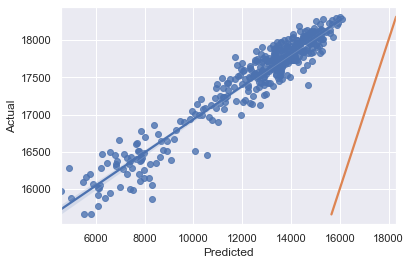

In [89]:
sns.regplot(x=y_pred_lin_inversed, y=y_test['Adj Close'])
ax = sns.regplot(x=y_test['Adj Close'], y=y_test['Adj Close'], scatter=False, fit_reg=True)
ax.set(xlabel='Predicted', ylabel='Actual')

In [90]:
lin2 = linear_model.LinearRegression()
lin2.fit(stock_data_train, y_train_final)
y_pred_lin2 = lin2.predict(stock_data_test)

y_pred_lin2_inversed = y_train_scaler.inverse_transform(y_pred_lin2)

r2_2 = r2_score(y_test['Adj Close'], y_pred_lin2_inversed)

mse_2 = mean_squared_error(y_test['Adj Close'], y_pred_lin2_inversed)
print('R^2:  ', r2_2)
print('MAE:  ', mean_absolute_error(y_test['Adj Close'], y_pred_lin2_inversed))
print('MSE:  ', mse_2)
print('RMSE: ', math.sqrt(mse_2))

R^2:   -76.4816569291739
MAE:   5021.278816696839
MSE:   29571104.886659633
RMSE:  5437.932041379299


[Text(0, 0.5, 'Actual'), Text(0.5, 0, 'Predicted')]

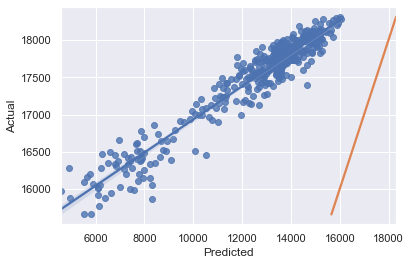

In [91]:
sns.regplot(x=y_pred_lin2_inversed, y=y_test['Adj Close'])
ax = sns.regplot(x=y_test['Adj Close'], y=y_test['Adj Close'], scatter=False, fit_reg=True)
ax.set(xlabel='Predicted', ylabel='Actual')

Text(0, 0.5, 'Adjacent Closing Price')

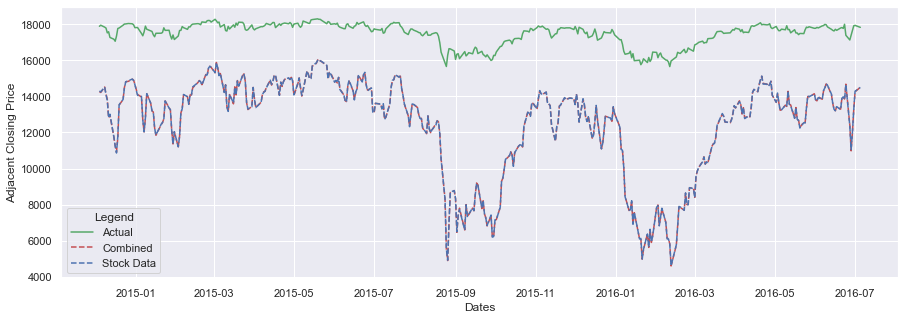

In [92]:
plt.figure(figsize=(15,5))
plt.plot(y_test1['Date'], y_test['Adj Close'], color='g', label='Actual')
plt.plot(y_test1['Date'], y_pred_lin_inversed, '--', color='r', label='Combined')
plt.plot(y_test1['Date'], y_pred_lin2_inversed, '--', color='b', label='Stock Data')
plt.legend(loc='best', title='Legend')
plt.xlabel('Dates')
plt.ylabel('Adjacent Closing Price')

In [93]:
lin3 = linear_model.LinearRegression()
lin3.fit(X_train_final[:,:25], y_train_final)
y_pred_lin3 = lin3.predict(X_test_final[:,:25])

y_pred_lin3_inversed = y_train_scaler.inverse_transform(y_pred_lin3)
r2_3 = r2_score(y_test['Adj Close'], y_pred_lin3_inversed)

mse_3 = mean_squared_error(y_test['Adj Close'], y_pred_lin3_inversed)
print('R^2:  ', r2_3)
print('MAE:  ', mean_absolute_error(y_test['Adj Close'], y_pred_lin3_inversed))
print('MSE:  ', mse_3)
print('RMSE: ', math.sqrt(mse_3))

R^2:   -66.0670724960624
MAE:   5021.278816696836
MSE:   25596347.752799816
RMSE:  5059.283324029187


[Text(0, 0.5, 'Actual'), Text(0.5, 0, 'Predicted')]

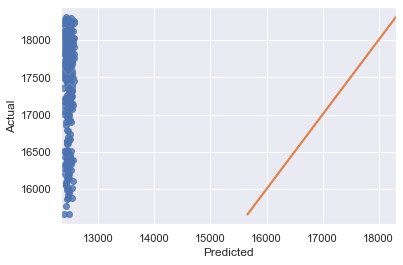

In [94]:
sns.regplot(x=y_pred_lin3_inversed, y=y_test['Adj Close'])
ax = sns.regplot(x=y_test['Adj Close'], y=y_test['Adj Close'], scatter=False, fit_reg=True)
ax.set(xlabel='Predicted', ylabel='Actual')

### 10.2) Support Vector Machines (SVM)

In [95]:
from sklearn.svm import SVR

svr = SVR(kernel='rbf')
svr.fit(X_train_final, y_train_final.ravel())
y_pred_svr = svr.predict(X_test_final)

In [96]:
y_pred_svr_inversed = y_train_scaler.inverse_transform(y_pred_svr)

r2 = r2_score(y_test['Adj Close'], y_pred_svr_inversed)

mse = mean_squared_error(y_test['Adj Close'], y_pred_svr_inversed)
print('R^2:  ', r2)
print('MAE:  ', mean_absolute_error(y_test['Adj Close'], y_pred_svr_inversed))
print('MSE:  ', mse)
print('RMSE: ', math.sqrt(mse))

R^2:   -69.81815388831839
MAE:   4918.3091659853735
MSE:   27027959.126188423
RMSE:  5198.842094754218


[Text(0, 0.5, 'Actual'), Text(0.5, 0, 'Predicted')]

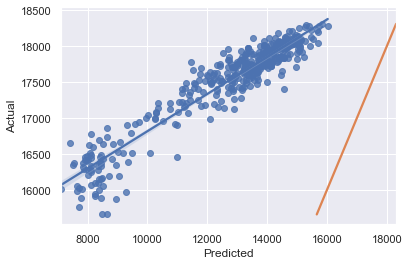

In [97]:
ax = sns.regplot(x=y_pred_svr_inversed, y=y_test['Adj Close'])
sns.regplot(x=y_test['Adj Close'], y=y_test['Adj Close'], scatter=False, fit_reg=True)
ax.set(xlabel='Predicted', ylabel='Actual')

In [98]:
svr2 = SVR(kernel='rbf')
svr2.fit(stock_data_train, y_train_final.ravel())
y_pred_svr2 = svr2.predict(stock_data_test)

y_pred_svr2_inversed = y_train_scaler.inverse_transform(y_pred_svr2)

r2_2 = r2_score(y_test['Adj Close'], y_pred_svr2_inversed)

mse_2 = mean_squared_error(y_test['Adj Close'], y_pred_svr2_inversed)
print('R^2:  ', r2_2)
print('MAE:  ', mean_absolute_error(y_test['Adj Close'], y_pred_svr2_inversed))
print('MSE:  ', mse_2)
print('RMSE: ', math.sqrt(mse_2))

R^2:   -70.43608389434645
MAE:   4918.20500225792
MSE:   27263793.951424196
RMSE:  5221.47430822217


[Text(0, 0.5, 'Actual'), Text(0.5, 0, 'Predicted')]

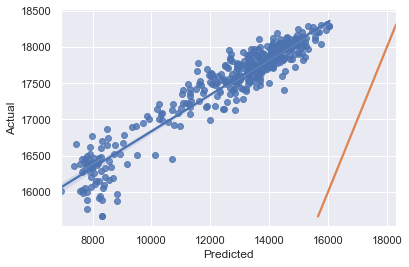

In [99]:
ax = sns.regplot(x=y_pred_svr2_inversed, y=y_test['Adj Close'])
sns.regplot(x=y_test['Adj Close'], y=y_test['Adj Close'], scatter=False, fit_reg=True)
ax.set(xlabel='Predicted', ylabel='Actual')

Text(0, 0.5, 'Adjacent Closing Price')

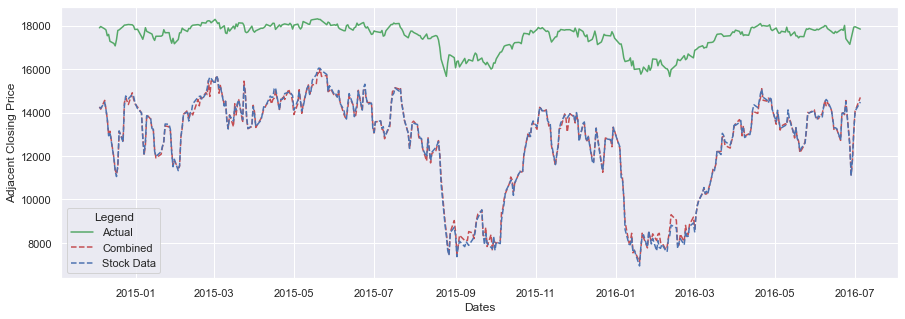

In [100]:
plt.figure(figsize=(15,5))
plt.plot(y_test1['Date'], y_test['Adj Close'], color='g', label='Actual')
plt.plot(y_test1['Date'], y_pred_svr_inversed, '--', color='r', label='Combined')
plt.plot(y_test1['Date'], y_pred_svr2_inversed, '--', color='b', label='Stock Data')
plt.legend(loc='best', title='Legend')
plt.xlabel('Dates')
plt.ylabel('Adjacent Closing Price')

In [101]:
svr3 = SVR(kernel='rbf')
svr3.fit(X_train_final[:,:25], y_train_final.ravel())
y_pred_svr3 = svr3.predict(X_test_final[:,:25])

y_pred_svr3_inversed = y_train_scaler.inverse_transform(y_pred_svr3)

r2_3 = r2_score(y_test['Adj Close'], y_pred_svr3_inversed)

mse_3 = mean_squared_error(y_test['Adj Close'], y_pred_svr3_inversed)
print('R^2:  ', r2_3)
print('MAE:  ', mean_absolute_error(y_test['Adj Close'], y_pred_svr3_inversed))
print('MSE:  ', mse_3)
print('RMSE: ', math.sqrt(mse_3))

R^2:   -72.51979822972903
MAE:   5212.0082923138125
MSE:   28059049.726888053
RMSE:  5297.079358182965


Text(0, 0.5, 'Adjacent Closing Price')

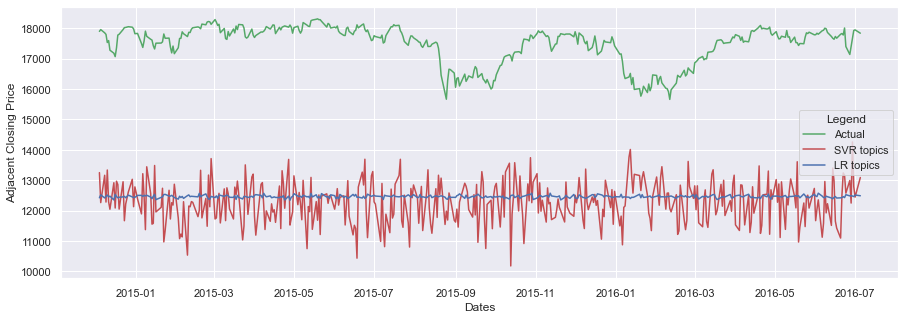

In [102]:
plt.figure(figsize=(15,5))
plt.plot(y_test1['Date'], y_test['Adj Close'], color='g', label='Actual')
plt.plot(y_test1['Date'], y_pred_svr3_inversed, color='r', label='SVR topics')
plt.plot(y_test1['Date'], y_pred_lin3_inversed, color='b', label='LR topics')
plt.legend(loc='best', title='Legend')
plt.xlabel('Dates')
plt.ylabel('Adjacent Closing Price')

### 10.3) RNN (LSTM)

In [103]:
# See another Jupyter Notebook.

pd.DataFrame(X_train_final).to_csv('X_train.csv', index=False)
pd.DataFrame(X_test_final).to_csv('X_test.csv', index=False)
pd.DataFrame(y_train['Adj Close']).to_csv('y_train.csv', index=False)
pd.DataFrame(y_test['Adj Close']).to_csv('y_test.csv', index=False)
pd.DataFrame(stock_data_train).to_csv('stock_data_train.csv', index=False)
pd.DataFrame(stock_data_test).to_csv('stock_data_test.csv', index=False)

In [163]:
pd.DataFrame(y_test1['Date']).to_csv('dates.csv', index=False)

### 10.4) Model Evaluations

In [130]:
actual_labels = []
y_test = y_test.reset_index(drop=True)
for i in range(len(y_test['Adj Close'])):
    if i==0:
        continue
    
    if y_test['Adj Close'][i] >= y_test['Adj Close'][i-1]:
        actual_labels.append(1)
    else:
        actual_labels.append(0)

In [131]:
all_labels = []
for i in range(len(y['Adj Close'])):
    if i==0:
        continue
    
    if y['Adj Close'][i] >= y['Adj Close'][i-1]:
        all_labels.append(1)
    else:
        all_labels.append(0)

In [132]:
train_labels = []
for i in range(len(y['Adj Close'])):
    if i==0:
        continue
    
    if y['Adj Close'][i] >= y['Adj Close'][i-1]:
        train_labels.append(1)
    else:
        train_labels.append(0)

In [133]:
def get_labels(pred_open):
    observed_labels = []
    for i in range(len(pred_open)):
        if i==0:
            continue

        if pred_open[i] >= pred_open[i-1]:
            observed_labels.append(1)
        else:
            observed_labels.append(0)
    
    return observed_labels

lin_labels = get_labels(y_pred_lin)
lin_labels2 = get_labels(y_pred_lin2)
svr_labels = get_labels(y_pred_svr)
svr_labels2 = get_labels(y_pred_svr2)

In [134]:
from sklearn.metrics import accuracy_score
accuracy_score(np.array(actual_labels), np.array(lin_labels))

0.4836272040302267

In [135]:
accuracy_score(np.array(actual_labels), np.array(lin_labels2))

0.4811083123425693

In [136]:
from sklearn.metrics import confusion_matrix
confusion_matrix(np.array(actual_labels), np.array(lin_labels))

array([[ 93, 102],
       [103,  99]], dtype=int64)

In [137]:
confusion_matrix(np.array(actual_labels), np.array(lin_labels2))

array([[ 93, 102],
       [104,  98]], dtype=int64)

In [138]:
accuracy_score(np.array(actual_labels), np.array(svr_labels))

0.473551637279597

In [139]:
accuracy_score(np.array(actual_labels), np.array(svr_labels2))

0.45843828715365237

In [140]:
confusion_matrix(np.array(actual_labels), np.array(svr_labels))

array([[ 89, 106],
       [103,  99]], dtype=int64)

In [141]:
confusion_matrix(np.array(actual_labels), np.array(svr_labels2))

array([[ 85, 110],
       [105,  97]], dtype=int64)

In [142]:
topic_probs = np.concatenate((X_train_topic_probs, X_test_topic_probs), axis=0)

In [143]:
topic_ids = [[] for i in range(len(topic_probs))]
counter=0
for i in range(len(topic_probs)):
    x=0
    for j in range(25):
        m = max(topic_probs[i][x*47:(x+1)*47])
        temp = [k for k, l in enumerate(topic_probs[i][x*47:(x+1)*47]) if l == m]
        #print(temp)
        topic_ids[i].append(temp[0])
        x+=1

In [144]:
topic_labels = pd.DataFrame(data=topic_ids)

In [145]:
topics = [i for i in range(47)]
label_counts = dict((el,[0,0]) for el in topics)

In [146]:
labels = []
for i in range(len(y['Adj Close'])):
    if i==0:
        if y['Adj Close'][i] >= 11655.42:
            labels.append(1)
            continue
        else:
            train_labels.append(0)
            continue
    
    if y['Adj Close'][i] >= y['Adj Close'][i-1]:
        labels.append(1)
    else:
        labels.append(0)

In [147]:
for i in range(len(labels)):
    label = labels[i]
    for j in range(25):
        topic = topic_labels.iloc[i,j]
        label_counts[topic][label] += 1

In [148]:
for i in range(47):
    label_counts[i] = label_counts[i][1] / (label_counts[i][0] + label_counts[i][1])

Text(0, 0.5, 'Label Counts')

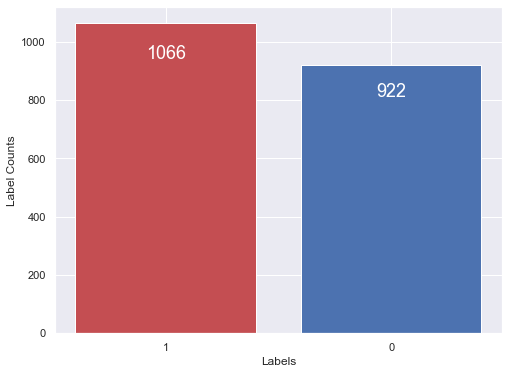

In [150]:
fig, ax = plt.subplots(1,1,figsize=(8,6))

counts = pd.Series(all_labels).value_counts()
ax.bar(['1','0'], counts, color=('r','b'))
rects = ax.patches

for rect, label, value in zip(rects, [1,0], [counts[1], counts[0]]):
    x_loc = rect.get_x()
    height = rect.get_height()
    width = rect.get_width()
    ax.text(x_loc + width/2, 0.9*height, value, ha='center', va='center', fontsize=18, color='white')
    
plt.xlabel('Labels')
plt.ylabel('Label Counts')

In [151]:
y['Adj Close'].describe()

count     1989.000000
mean     13466.102290
std       3145.299158
min       6547.049805
25%      10913.379883
50%      13029.259766
75%      16479.880859
max      18312.390625
Name: Adj Close, dtype: float64

Text(0, 0.5, 'Adjacency Closing Price')

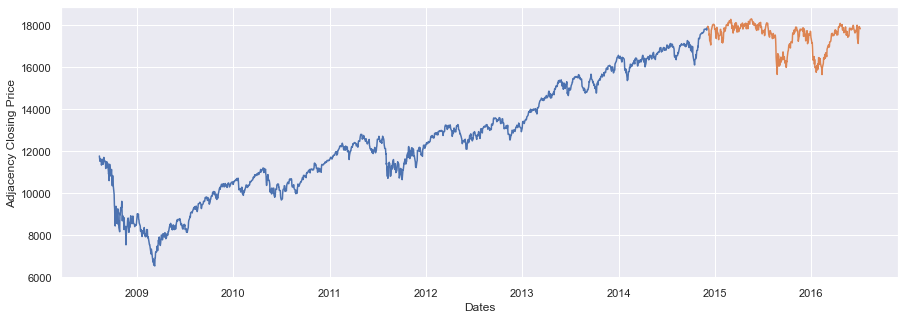

In [152]:
plt.figure(figsize=(15,5))
plt.plot(y_train1['Date'], y_train['Adj Close'])
plt.plot(y_test1['Date'], y_test1['Adj Close'])
plt.xlabel('Dates')
plt.ylabel('Adjacency Closing Price')

In [153]:
X_train['Adj Close'].mean()

12457.458341417987

In [158]:
print(y_pred_lin_inversed.mean())
print(y_pred_lin2_inversed.mean())

12461.341621637328
12461.34162163733


In [156]:
print(y_pred_svr_inversed.mean())
print(y_pred_svr2_inversed.mean())

12564.311272348798
12564.415436076251


In [161]:
pd.DataFrame({'a':{'1':1, '2':2}, 'b':{'1':1, '2':2}})

,a,b
1,1,1
2,2,2
